In [1]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import ta
import requests
from dotenv import load_dotenv
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Dropout, Input, Flatten
import xgboost as xgb


In [2]:
def fetch_stock_data(stock_name, interval="1h", period="6mo"):  
    stock = yf.Ticker(stock_name)
    df = stock.history(period=period, interval=interval) 
    
    df = df[["Open", "High", "Low", "Close", "Volume"]].dropna()

    return df

stock_name = "AAPL"  # Change stock symbol as needed
stock_data = fetch_stock_data(stock_name)

In [3]:
stock_data["RSI"] = ta.momentum.RSIIndicator(stock_data["Close"], window=14).rsi()

macd = ta.trend.MACD(stock_data["Close"])
stock_data["MACD"] = macd.macd()
stock_data["Signal_Line"] = macd.macd_signal()

bb = ta.volatility.BollingerBands(stock_data["Close"], window=20, window_dev=2)
stock_data["Upper_Band"] = bb.bollinger_hband()
stock_data["Lower_Band"] = bb.bollinger_lband()

stock_data["VWAP"] = ta.volume.VolumeWeightedAveragePrice(
    stock_data["High"], stock_data["Low"], stock_data["Close"], stock_data["Volume"]
).volume_weighted_average_price()

adx = ta.trend.ADXIndicator(stock_data["High"], stock_data["Low"], stock_data["Close"])
stock_data["ADX"] = adx.adx()

stock_data.dropna(inplace=True)



In [4]:
required_features = ["Close", "RSI", "MACD", "VWAP", "ADX"]

missing_features = [col for col in required_features if col not in stock_data.columns]
if missing_features:
    print(f"❌ Error: Missing columns {missing_features}")
else:
    print(f"✅ All required features are present!")

print(stock_data.isnull().sum())

✅ All required features are present!
Open           0
High           0
Low            0
Close          0
Volume         0
RSI            0
MACD           0
Signal_Line    0
Upper_Band     0
Lower_Band     0
VWAP           0
ADX            0
dtype: int64


In [5]:
import requests
from nltk.sentiment import SentimentIntensityAnalyzer

def get_stock_news_sentiment_vader(stock_name):
    api_key = "084eb76cbfac4a0ba55fc1a33880"  
    url = f"https://newsapi.org/v2/everything?q={stock_name}&apiKey={api_key}"
    
    response = requests.get(url).json()

    if "articles" not in response or not response["articles"]:
        return "No recent news available.", "Neutral"

    latest_news_title = response["articles"][0]["title"] 
    sia = SentimentIntensityAnalyzer()
    
    sentiment_score = sia.polarity_scores(latest_news_title)['compound']

    if sentiment_score > 0.05:
        sentiment = "Positive"
    elif sentiment_score < -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    return latest_news_title, sentiment

# Example 1
stock_name = "TSLA"  # Tesla stock
news, sentiment = get_stock_news_sentiment_vader(stock_name)

print(f"Latest News: {news}")
print(f"Market Sentiment: {sentiment}")




Latest News: Tesla (TSLA) Maintains “Buy” Rating as AI and Robotics Drive Growth Potential
Market Sentiment: Positive


In [6]:
# Example 2
stock_name = "GOOGL"  # google stock
news, sentiment = get_stock_news_sentiment_vader(stock_name)

print(f"Latest News: {news}")
print(f"Market Sentiment: {sentiment}")

Latest News: Google Co-Founder Says Employees Should Be In The Office "At Least" Every Weekday As Competition In The AI Arms Race Intensifies
Market Sentiment: Neutral


In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
stock_data_scaled = scaler.fit_transform(stock_data[["Close", "RSI", "MACD", "VWAP", "ADX"]])

scaled_df = pd.DataFrame(stock_data_scaled, columns=["Close", "RSI", "MACD", "VWAP", "ADX"], index=stock_data.index)

In [8]:
X_train, y_train = [], []
window_size = 60  

for i in range(window_size, len(scaled_df) - 1):
    X_train.append(scaled_df.iloc[i-window_size:i].values)
    y_train.append(scaled_df["Close"].iloc[i+1])  

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of X_train (LSTM):", X_train.shape)  

Shape of X_train (LSTM): (760, 60, 5)


In [9]:
model = Sequential([
    Input(shape=(60, 5)),  
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    LSTM(units=50, return_sequences=True),
    Dropout(0.3),
    LSTM(units=50),
    Dense(units=1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1011 - val_loss: 0.0658
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0065 - val_loss: 0.0096
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0055 - val_loss: 0.0071
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0046 - val_loss: 0.0078
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0043 - val_loss: 0.0125
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0044 - val_loss: 0.0076
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0051 - val_loss: 0.0139
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0041 - val_loss: 0.0080
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

In [10]:
selected_features = ["Close", "RSI", "MACD", "VWAP", "ADX"]
X = scaled_df[selected_features].values
y = scaled_df["Close"].shift(-1).dropna().values  

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X[:-1], y, test_size=0.2, random_state=42)

print("X_train_xgb shape:", X_train_xgb.shape)
print("y_train_xgb shape:", y_train_xgb.shape)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

X_train_xgb shape: (656, 5)
y_train_xgb shape: (656,)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.save("lstm_model.keras", include_optimizer=False)
xgb_model.save_model("xgb_model.json")

In [12]:
from tensorflow.keras.models import load_model
import xgboost as xgb

# LSTM model
try:
    lstm_model = load_model("lstm_model.keras")  
    print("LSTM model loaded successfully!")
except Exception as e:
    print(f"Error loading LSTM model: {e}")

# XGBoost model
try:
    xgb_model = xgb.XGBRegressor()
    xgb_model.load_model("xgb_model.json")  
    print("XGBoost model loaded successfully!")
except Exception as e:
    print(f"Error loading XGBoost model: {e}")


LSTM model loaded successfully!
XGBoost model loaded successfully!


In [13]:
feature_scaler = MinMaxScaler(feature_range=(0,1))
close_scaler = MinMaxScaler(feature_range=(0,1))

stock_data_scaled = feature_scaler.fit_transform(stock_data[["Close", "RSI", "MACD", "VWAP", "ADX"]])
stock_data["Close_Scaled"] = close_scaler.fit_transform(stock_data[["Close"]])


In [14]:
def predict_next_hours(stock_data, hours=1):
    required_features = ["Close", "RSI", "MACD", "VWAP", "ADX"]

    missing_features = [col for col in required_features if col not in stock_data.columns]
    if missing_features:
        print(f"Error: Missing columns {missing_features}")
        print("Available columns:", stock_data.columns)
        return None

    if lstm_model is None or xgb_model is None:
        print("Error: LSTM or XGBoost model is not loaded!")
        return None

    stock_data.fillna(0, inplace=True)

    try:
        last_window = stock_data[required_features].values[-60:].copy()  

        predicted_values = []

        for _ in range(hours):
            X_input_lstm = np.array([last_window])  
            X_input_xgb = last_window[-1].reshape(1, -1)  

            lstm_pred_scaled = lstm_model.predict(X_input_lstm)[0][0]
            xgb_pred_scaled = xgb_model.predict(X_input_xgb)[0]

            final_pred_scaled = (lstm_pred_scaled + xgb_pred_scaled) / 2

            final_pred_original = close_scaler.inverse_transform([[final_pred_scaled]])[0][0]
            predicted_values.append(final_pred_original)

            last_window = np.roll(last_window, shift=-1, axis=0) 
            last_window[-1][0] = final_pred_scaled 

        return predicted_values[-1]  

    except Exception as e:
        print(f"⚠️ Error in prediction: {e}")
        return None


In [15]:
print("Last 5 Close Prices:", stock_data["Close"].tail(5).values)

selected_hours = 3 
predicted_price = predict_next_hours(stock_data, selected_hours)

print(f"Predicted Price in {selected_hours} Hours: {predicted_price}")


Last 5 Close Prices: [223.72999573 224.07449341 223.72000122 223.67500305 222.47999573]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Price in 3 Hours: 268.91232014199704


In [16]:
for hours in [1, 3, 7]:
    predicted_price = predict_next_hours(stock_data, hours)
    print(f"Predicted Price in {hours} Hours: {predicted_price}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Price in 1 Hours: 289.6499386328869
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Price in 3 Hours: 268.91232014199704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Price in 7 Hours: 277.30960182908893


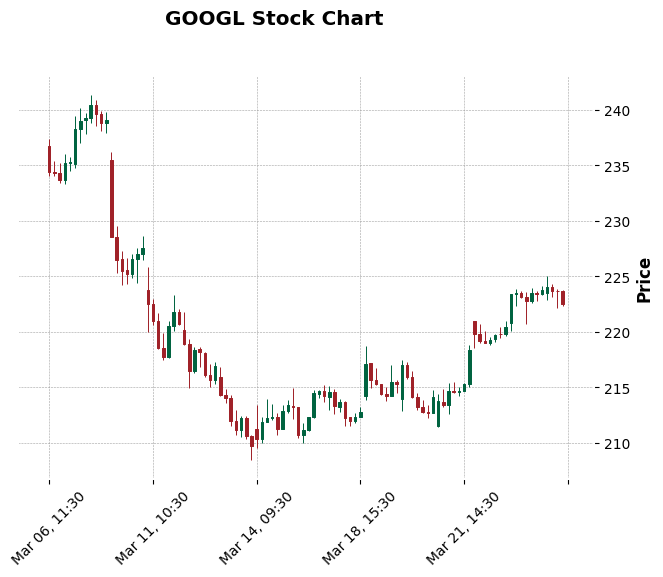

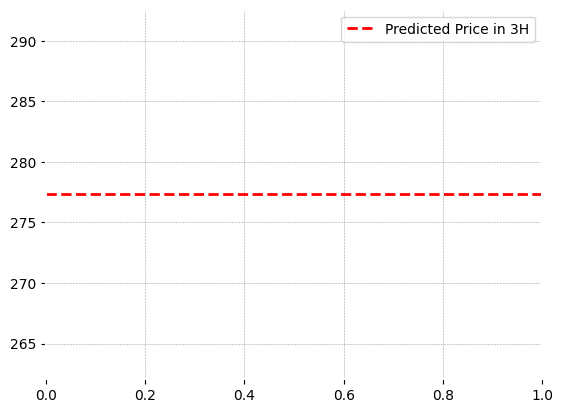

In [17]:
import mplfinance as mpf
import matplotlib.pyplot as plt

mpf.plot(stock_data.tail(100), type='candle', style='charles', title=f"{stock_name} Stock Chart")

plt.axhline(y=predicted_price, color='r', linestyle='--', label=f"Predicted Price in {selected_hours}H")
plt.legend()
plt.show()


In [18]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor()
xgb_model.load_model("xgb_model.json")

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_xgb = xgb_model.predict(X_test_xgb)
mse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb)
r2_xgb = r2_score(y_test_xgb, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"R² Score: {r2_xgb:.2f} (Closer to 1 is better)")


XGBoost Model Performance:
Mean Squared Error: 0.0010078075304928598
R² Score: 0.98 (Closer to 1 is better)


In [20]:
from tensorflow.keras.models import load_model

model = load_model("lstm_model.keras", compile=False)

model.compile(optimizer="rmsprop", loss="mean_squared_error")

print("Model loaded and recompiled successfully!")


Model loaded and recompiled successfully!


In [21]:
import os

if os.path.exists("xgb_model.json"):
    xgb_model = xgb.XGBRegressor()
    xgb_model.load_model("xgb_model.json")
    print("Model loaded successfully!")
else:
    print("Error: xgb_model.json not found! Train and save the model first.")


Model loaded successfully!


In [22]:
import os
print(os.getcwd())  
print(os.listdir())

C:\Juputer Notebook
['.ipynb_checkpoints', 'AI_loan_approval_guide.ipynb', 'cleaned_data.json', 'document_extraction.ipynb', 'house_price_model.pkl', 'House_price_prediction.ipynb', 'house_price_prediction_app', 'Iris_flower_classification.ipynb', 'iris_model.pkl', 'loan_app.py', 'loan_model.pkl', 'lstm_model.h5', 'lstm_model.keras', 'models', 'path_to_extract', 'rag_app.ipynb', 'rag_app.py', 'seaborn.ipynb', 'stock.py', 'stock_price_prediction.ipynb', 'xgb_model.json']


In [25]:
import yfinance as yf
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

xgb_model = xgb.XGBRegressor()
xgb_model.load_model("xgb_model.json") 

close_scaler = MinMaxScaler(feature_range=(0, 1))

def fetch_stock_data(stock_name, interval="1h", period="6mo"):
    """Fetch stock data using Yahoo Finance API"""
    stock = yf.Ticker(stock_name)
    df = stock.history(period=period, interval=interval)
    
    if df.empty:
        print("❌ Error: Invalid Stock Name or No Data Found!")
        return None
    
    df = df[["Open", "High", "Low", "Close", "Volume"]].dropna()

    return df

def preprocess_data(stock_data):
    """Compute technical indicators and normalize data"""
    stock_data["RSI"] = ta.momentum.RSIIndicator(stock_data["Close"], window=14).rsi()
    
    macd = ta.trend.MACD(stock_data["Close"])
    stock_data["MACD"] = macd.macd()

    stock_data["VWAP"] = ta.volume.VolumeWeightedAveragePrice(
        stock_data["High"], stock_data["Low"], stock_data["Close"], stock_data["Volume"]
    ).volume_weighted_average_price()

    adx = ta.trend.ADXIndicator(stock_data["High"], stock_data["Low"], stock_data["Close"])
    stock_data["ADX"] = adx.adx()

    stock_data.dropna(inplace=True)
    
  
    features = ["Close", "RSI", "MACD", "VWAP", "ADX"]
    stock_data_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(stock_data[features])
    
    scaled_df = pd.DataFrame(stock_data_scaled, columns=features, index=stock_data.index)
   
    stock_data["Close_Scaled"] = close_scaler.fit_transform(stock_data[["Close"]])
    
    return scaled_df

def predict_stock_price(stock_data, hours=1):
    """Predict stock price using XGBoost model"""
    required_features = ["Close", "RSI", "MACD", "VWAP", "ADX"]

    if any(col not in stock_data.columns for col in required_features):
        print("❌ Error: Missing required features!")
        return None

    last_window = stock_data[required_features].values[-1].reshape(1, -1)

    predicted_price_scaled = xgb_model.predict(last_window)[0]
    predicted_price = close_scaler.inverse_transform([[predicted_price_scaled]])[0][0]

    return predicted_price


stock_name = input("Enter the stock symbol (e.g., AAPL, TSLA, GOOG): ").strip().upper()
stock_data = fetch_stock_data(stock_name)

if stock_data is not None:
    stock_data = preprocess_data(stock_data)

    hours = int(input("Enter prediction time (1, 3, or 7 hours): ").strip())

    predicted_price = predict_stock_price(stock_data, hours)
    print(f"\n Predicted Price of {stock_name} in {hours} hours: {predicted_price:.2f}")


Enter the stock symbol (e.g., AAPL, TSLA, GOOG):  SI=F
Enter prediction time (1, 3, or 7 hours):  7



 Predicted Price of SI=F in 7 hours: 34.15
